# Predicting the cost of cars

Used car dealership develops app to attract new customers. In it, you can quickly find out the market value of your car. Historical data: technical characteristics, configurations and prices of cars. You need to build a model determine the cost. 

The customer is important:
- quality if prediction
- prediction speed
- studying time

## Import Libraries and Tools

In [1]:
!pip install missingno -U

In [2]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lightgbm 

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import timeit
import warnings


from category_encoders import TargetEncoder
import missingno
import lightgbm as lgb

Warning are not displayed

In [6]:
warnings.filterwarnings('ignore')

## Data preparation

In [8]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [9]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Handling Missing Values

In [10]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

<AxesSubplot:>

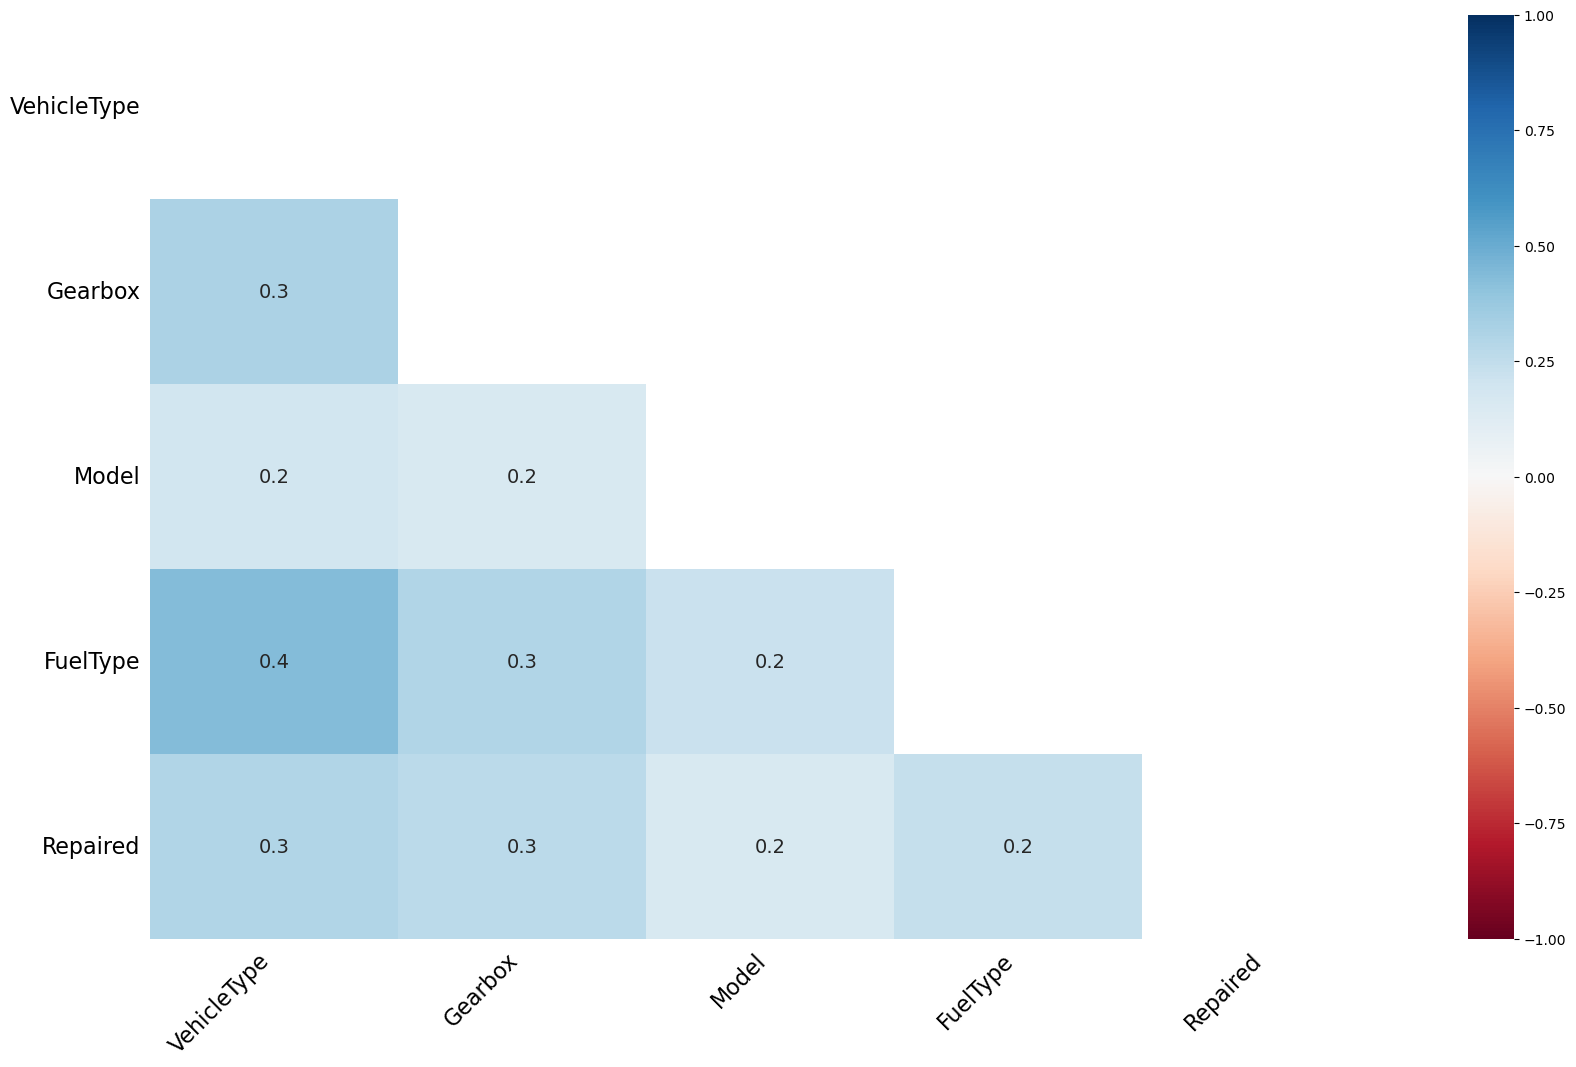

In [11]:
missingno.heatmap(df)

**Conclusion:** 5 features have missing values and weak correlation. Before getting rid of missing values, it is necessary to check whether there are strongly correlated features in the overall dataset 

### Remove the missing values in each of the 5 features:
- VehicleType
- Model
- FuelType
- Gearbox
- Repaired

We will remove all missing values using machine learning algorithms – classification and regression. The attribute in which we will remove missing values will be called the Target attribute. For each such feature, we define a set of features that affect this

### Initializing useful functions

**Calculates the percentage of missing values from the total number of objects in the dataset**

In [12]:
def print_per_na(feature):
    return f'{(df[feature].isna().sum() / df.shape[0] * 100).round(2)}%'

**Preparation of training and test datasets**

In [13]:
def prepare_data(features, target):
    is_obj = False
    df_new = pd.DataFrame()
    for feature in features:
        df_new[feature] = df[feature]
        if df[feature].dtype == 'O':
            is_obj = True
    df_new[target] = df[target]
    
    df_test = df_new[df_new[target].isna()]
    df_train = df_new[~df_new[target].isna()]
    
    features_test = df_test.drop([target], axis=1)
    target_test = df_test[target]
    
    features_train = df_train.drop([target], axis=1)
    target_train = df_train[target]
    
    if is_obj:
        model = OrdinalEncoder()
        array_feat_test = model.fit_transform(features_test)
        array_feat_train = model.fit_transform(features_train)
        features_test = pd.DataFrame(array_feat_test, index=features_test.index, columns=features_test.columns)
        features_train = pd.DataFrame(array_feat_train, index=features_train.index, columns=features_train.columns)
    
    return features_train, features_test, target_train, target_test

**Getting a completed feature**

In [15]:
def join_predictions(features_train, target_train, features_test, target_predict, target_name):
    df_predict = pd.DataFrame(data=target_predict, index=features_test.index, columns=[target_name])
    features_train[target_name] = target_train
    df_intermediate = pd.concat([features_test.join(df_predict), features_train])
    return df_intermediate[target_name]

### VehicleType

In [16]:
print_per_na("VehicleType")

'10.58%'

In [17]:
df.groupby('VehicleType')['VehicleType'].count().sort_values(ascending=False)

VehicleType
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

There are too many missing data in the attribute, so we will not delete them, but fill in these values. Also no implicit missing values found

For the target feature VehicleType, the significant feature is Power

Let's check the expediency of including in Power as a feature for model training

In [18]:
df.pivot_table(index=['VehicleType'], values='Power', aggfunc=['mean', 'median'])

,mean,median
,Power,Power
VehicleType,,
bus,111.588115,110
convertible,131.660050,122
coupe,153.186475,148
other,97.325426,85
sedan,127.536383,116
small,68.519234,64
suv,154.374708,150
wagon,133.744560,131


First of all, we note that the data skewness of the Power feature is quite low, which means we can notice that each category has its own power range. Therefore, the feature is chosen correctly

In [19]:
features_train_veh, features_test_veh, target_train_veh, target_test_veh = prepare_data(['Power'], 'VehicleType')
print(features_train_veh.shape)
print(features_test_veh.shape)
print(target_train_veh.shape)
print(target_test_veh.shape)

(316879, 1)
(37490, 1)
(316879,)
(37490,)


We solve the classification problem and choose the best quality model

In [20]:
model_tree_veh = DecisionTreeClassifier(random_state=12345, max_depth=200, min_samples_leaf=500)
scores_veh = cross_val_score(model_tree_veh, features_train_veh, target_train_veh, cv=5)
final_score_veh = sum(scores_veh) / len(scores_veh)
final_score_veh

0.4549749180745006

In [21]:
model_forest_veh = RandomForestClassifier(random_state=12345, n_estimators=80, max_depth=200, min_samples_leaf=500)
scores_veh = cross_val_score(model_forest_veh, features_train_veh, target_train_veh, cv=5)
final_score_veh = sum(scores_veh) / len(scores_veh)
final_score_veh

0.4530404249619192

In [22]:
model_logic_veh = LogisticRegression(random_state=12345, max_iter=3000)
scores_veh = cross_val_score(model_logic_veh, features_train_veh, target_train_veh, cv=5)
final_score_veh = sum(scores_veh) / len(scores_veh)
final_score_veh

0.43593611120655185

The highest quality model is DecisionTreeClassifier. Let's fill in the blanks

In [23]:
model_tree_veh.fit(features_train_veh, target_train_veh)
target_predict_veh = model_tree_veh.predict(features_test_veh)


Let's fill in the missing values of the feature and attach it to our dataset

In [24]:
df['VehicleType'] = join_predictions(features_train_veh, target_train_veh, features_test_veh, target_predict_veh, 'VehicleType')
df['VehicleType'].isna().sum()


0

### Model

In [25]:
print_per_na('Model')

'5.56%'

In [26]:
df.groupby('Brand')['Model'].count().sort_values(ascending=False)

Brand
volkswagen        73508
opel              38060
bmw               34979
mercedes_benz     30836
audi              28173
ford              24166
renault           17192
peugeot           10107
fiat               9141
seat               6672
skoda              5359
mazda              5263
smart              4978
citroen            4899
nissan             4734
toyota             4449
hyundai            3359
mini               3140
volvo              3101
mitsubishi         2862
honda              2662
kia                2352
suzuki             2186
alfa_romeo         2177
chevrolet          1644
chrysler           1350
dacia               878
daihatsu            767
subaru              718
porsche             716
jeep                651
land_rover          532
saab                510
daewoo              496
trabant             494
jaguar              491
lancia              448
rover               404
lada                210
sonstige_autos        0
Name: Model, dtype: int64

The percentage of missing values from the entire dataset is slightly more than five percent. No implicit duplicates found. Let's highlight the signs that can fill in the missing values:
- Brand
- RegistrationYear
- VehicleType

In [27]:
features_train_mdl, features_test_mdl, target_train_mdl, target_test_mdl = prepare_data(['Brand', 'RegistrationYear', 'VehicleType'], 'Model')
print(features_train_mdl.shape)
print(features_test_mdl.shape)
print(target_train_mdl.shape)
print(target_test_mdl.shape)

(334664, 3)
(19705, 3)
(334664,)
(19705,)


We solve the classification problem and choose the best quality model

In [28]:
model_tree_mdl = DecisionTreeClassifier(random_state=12345, max_depth=500, min_samples_leaf=500)
scores_mdl = cross_val_score(model_tree_mdl, features_train_mdl, target_train_mdl, cv=5)
final_score_mdl = sum(scores_mdl) / len(scores_mdl)
final_score_mdl

0.5630034948913721

In [29]:
model_forest_mdl = RandomForestClassifier(random_state=12345, n_estimators=120, max_depth=200, min_samples_leaf=500)
scores_mdl = cross_val_score(model_forest_mdl, features_train_mdl, target_train_mdl, cv=5)
final_score_mdl = sum(scores_mdl) / len(scores_mdl)
final_score_mdl

0.5189443803541337

The highest quality model is DecisionTreeClassifier. Let's fill in the blanks

In [30]:
model_tree_mdl.fit(features_train_mdl, target_train_mdl)
target_predict_mdl = model_tree_mdl.predict(features_test_mdl)

Let's fill in the missing values of the features and attach it to our dataset

In [31]:
df['Model'] = join_predictions(features_train_mdl, target_train_mdl, features_test_mdl, target_predict_mdl, 'Model')
df['Model'].isna().sum()

0

### FuelType

In [32]:
print_per_na('FuelType')

'9.28%'

In [33]:
df.groupby('FuelType')['FuelType'].count().sort_values(ascending=False)

FuelType
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

The percentage of missing values from the entire dataset is slightly more than nine percent. No implicit duplicates found. Let's highlight the features that can fill in the missing values:
- Model
- RegistrationYear

In [34]:
features_train_ft, features_test_ft, target_train_ft, target_test_ft = prepare_data(['Brand', 'RegistrationYear'], 'FuelType')
print(features_train_ft.shape)
print(features_test_ft.shape)
print(target_train_ft.shape)
print(target_test_ft.shape)


(321474, 2)
(32895, 2)
(321474,)
(32895,)


We solve the classification problem and choose the best quality model

In [35]:
model_tree_ft = DecisionTreeClassifier(random_state=12345, max_depth=500, min_samples_leaf=500)
scores_ft = cross_val_score(model_tree_ft, features_train_ft, target_train_ft, cv=5)
final_score_ft = sum(scores_ft) / len(scores_ft)
final_score_ft

0.7238781286407862

In [36]:
model_forest_ft = RandomForestClassifier(random_state=12345, n_estimators=160, max_depth=300, min_samples_leaf=500)
scores_ft = cross_val_score(model_forest_ft, features_train_ft, target_train_ft, cv=5)
final_score_ft = sum(scores_ft) / len(scores_ft)
final_score_ft

0.7243478416680115

The highest quality model is DecisionTreeClassifier. Let's fill in the blanks

In [37]:
model_tree_ft.fit(features_train_ft, target_train_ft)
target_predict_ft = model_tree_ft.predict(features_test_ft)

Let's fill in the missing values of the feature and attach it to our dataset

In [38]:
df['FuelType'] = join_predictions(features_train_ft, target_train_ft, features_test_ft, target_predict_ft, 'FuelType')
df['FuelType'].isna().sum()


0

In [39]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox              19833
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

### Gearbox

In [40]:
print_per_na('Gearbox')

'5.6%'

In [41]:
df.groupby('Gearbox')['Gearbox'].count().sort_values(ascending=False)

Gearbox
manual    268251
auto       66285
Name: Gearbox, dtype: int64

The percentage of missing values from the entire dataset is slightly more than five percent. No implicit duplicates found. Let's highlight the signs that can fill in the missing values:
- Model
- RegistrationYear
- FuelType
- Power

In [42]:
features_train_gb, features_test_gb, target_train_gb, target_test_gb = prepare_data(['Model', 'RegistrationYear', 'FuelType', 'Power'], 'Gearbox')
print(features_train_gb.shape)
print(features_test_gb.shape)
print(target_train_gb.shape)
print(target_test_gb.shape)


(334536, 4)
(19833, 4)
(334536,)
(19833,)


We solve the classification problem and choose the best quality model

In [43]:
model_tree_gb = DecisionTreeClassifier(random_state=12345, max_depth=500, min_samples_leaf=500)
scores_gb = cross_val_score(model_tree_gb, features_train_gb, target_train_gb, cv=5)
final_score_gb = sum(scores_gb) / len(scores_gb)
final_score_gb

0.8524284422731621

In [44]:
model_forest_gb = RandomForestClassifier(random_state=12345, n_estimators=160, max_depth=300, min_samples_leaf=500)
scores_gb = cross_val_score(model_forest_gb, features_train_gb, target_train_gb, cv=5)
final_score_gb = sum(scores_gb) / len(scores_gb)
final_score_gb

0.8532833571216571

The highest quality model is RandomForestClassifier. Let's fill in the blanks

In [45]:
model_forest_gb.fit(features_train_gb, target_train_gb)
target_predict_gb = model_forest_gb.predict(features_test_gb)

Let's fill in the missing values of the feature and attach it to our dataset

In [46]:
df['Gearbox'] = join_predictions(features_train_gb, target_train_gb, features_test_gb, target_predict_gb, 'Gearbox')
df['Gearbox'].isna().sum()


0

### Repaired

In [47]:
print_per_na('Repaired')

'20.08%'

In [48]:
df.groupby('Repaired')['Repaired'].count().sort_values(ascending=False)

Repaired
no     247161
yes     36054
Name: Repaired, dtype: int64

The share of missing values from the entire dataset is slightly more than twenty percent. No implicit duplicates found. Let's highlight the signs that can fill in the missing values:
- Kilometer
- RegistrationYear
- Model

In [49]:
df.pivot_table(index=['Repaired'], values='Kilometer', aggfunc=['mean'])

,mean
,Kilometer
Repaired,
no,126395.588301
yes,136178.093970


In [50]:
features_train_rep, features_test_rep, target_train_rep, target_test_rep = prepare_data(['Kilometer', 'RegistrationYear', 'Model'], 'Repaired')
print(features_train_rep.shape)
print(features_test_rep.shape)
print(target_train_rep.shape)
print(target_test_rep.shape)


(283215, 3)
(71154, 3)
(283215,)
(71154,)


We solve the classification problem and choose the best quality model

In [51]:
model_tree_rep = DecisionTreeClassifier(random_state=12345, max_depth=500, min_samples_leaf=500)
scores_rep = cross_val_score(model_tree_rep, features_train_rep, target_train_rep, cv=5)
final_score_rep = sum(scores_rep) / len(scores_rep)
final_score_rep

0.8726974206874637

In [52]:
model_forest_rep = RandomForestClassifier(random_state=12345, n_estimators=160, max_depth=300, min_samples_leaf=500)
scores_rep = cross_val_score(model_forest_rep, features_train_rep, target_train_rep, cv=5)
final_score_rep = sum(scores_rep) / len(scores_rep)
final_score_rep

0.8726974206874637

Both models are of good quality. Let's fill in the blanks

In [53]:
model_tree_rep.fit(features_train_rep, target_train_rep)
target_predict_rep = model_tree_rep.predict(features_test_rep)

Let's fill in the missing values of the feature and attach it to our dataset

In [54]:
df['Repaired'] = join_predictions(features_train_rep, target_train_rep, features_test_rep, target_predict_rep, 'Repaired')
df['Repaired'].isna().sum()


0

Check the dataset for missing values

In [55]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

All missing values are filled using ML classification models. This made it possible to avoid deleting part of the data and reducing the dataset.

### Removing non-informative features

Remove the following features:
- DateCrawled (server info)
- DateCreated (server info)
- LastSeen (server info)
- RegistrationMonth (the most important attribute of RegistrationYear)
- PostalCode (does not affect the cost of the car)
- NumberOfPictures (feature has only zero value - not informative)

**DateCrawled**

In [56]:
df = df.drop(['DateCrawled'], axis=1)

**LastSeen**

In [57]:
df = df.drop(['LastSeen'], axis=1)

**RegistrationMonth**

In [58]:
df.pivot_table(index=['RegistrationMonth'], values='Price', aggfunc=['mean'])

,mean
,Price
RegistrationMonth,
0,1907.968757
1,4670.885783
2,4581.080218
3,4585.424228
4,4744.656577
5,4623.699345
6,4706.366859
7,4798.471944


In [59]:
df = df.drop(['RegistrationMonth'], axis=1)

**Conclusion:** The average cost of a car practically does not depend on the month of its registration. However, there is an anomalous value of 0, which most likely indicates the presence of a gap. Feature can be removed

**PostalCode**

In [60]:
def cat_pc(row):
    post_code = row['PostalCode']
    if post_code > 9999 and post_code < 20000:
        return 1
    elif post_code > 19999 and post_code < 30000:
        return 2
    elif post_code > 29999 and post_code < 40000:
        return 3
    elif post_code > 39999 and post_code < 50000:
        return 4
    elif post_code > 49999 and post_code < 60000:
        return 5
    elif post_code > 59999 and post_code < 70000:
        return 6
    elif post_code > 69999 and post_code < 80000:
        return 7
    elif post_code > 79999 and post_code < 90000:
        return 8
    elif post_code > 89999 and post_code < 100000:
        return 9
    else:
        return 'other'
    
df['cat_post'] = df.apply(cat_pc, axis=1)
df.pivot_table(index=['cat_post'], values='Price', aggfunc=['mean', 'count'])

,mean,count
,Price,Price
cat_post,,
1,4087.786794,27532
2,4034.304689,42614
3,4273.798095,43565
4,4151.110569,49164
5,4358.233280,46682
6,4718.694822,35150
7,4892.637644,31676
8,5200.453034,32055


In [61]:
df = df.drop(['cat_post'], axis=1)
df = df.drop(['PostalCode'], axis=1)

**Conclusion:** In the code above, we created groups of zip codes, after which we concluded that the average price is distributed evenly among the created classes (deviations are compensated by the average of the other group). Let's remove this feature, as well as the auxiliary column "cat_post"

**NumberOfPictures**

In [62]:
df = df.drop(['NumberOfPictures'], axis=1)

**Conclusion:** The feature is removed due to its lack of information

In total, there are 10 features left in our dataset

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          354369 non-null  object
 10  DateCreated       354369 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


### Handling anomalous values

In the beginning, we will study all the numerical features:
- Price
- RegistrationYear
- Power
- Kilometer \
Remove outliers, change data type (if necessary)

Then we will study all categorical features:
- VehicleType
- Gearbox
- Model
- FuelType
- Brand
- Repaired \
Remove implicit duplicates, change data type (if necessary)

### Initializing useful functions

**Calculation of the right and left whiskers**

In [64]:
def right_whisker(data, column):
    quant1 = data[column].quantile(0.25)
    quant3 = data[column].quantile(0.75)
    IQR = quant3 - quant1
    right_whisker = quant3 + 1.5 * IQR
    return right_whisker

def left_whisker(data, column):
    quant1 = data[column].quantile(0.25)
    quant3 = data[column].quantile(0.75)
    IQR = quant3 - quant1
    left_whisker = quant1 - 1.5 * IQR
    return left_whisker

### Price

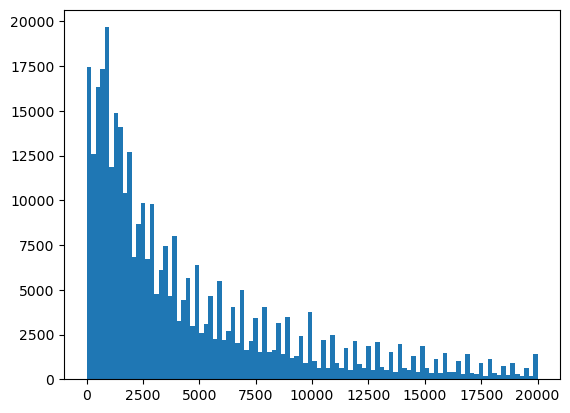

In [65]:
plt.hist(df['Price'], bins=100)
plt.show()

In [66]:
df['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [67]:
len(df[df['Price'] > right_whisker(df, 'Price')]) / len(df) * 100

5.355716781095412

In [68]:
df[df['Price'] == 0]['Price'].count() / df.shape[0] * 100

3.0397692800442475

In [69]:
df = df[df['Price'] > 0]

In [70]:
df['Price'] = df['Price'].astype('int32')

**Conclusion:** The data of the attribute is skewed to the left - there are much more cheap cars. The spread of values is only 5.35%, which does not require removal on the right. However, 3% of the data has Price = 0, which is noise. We removed these objects, since there are not too many of them, and they can significantly affect predictions. We also changed the data type to int32

### RegistrationYear

In [71]:
MAX_YEAR = max(pd.DatetimeIndex(df['DateCreated']).year)

In [72]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 5000, 1958, 1967, 1959, 1956,
       3200, 1000, 1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957,
       1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953, 1954, 1234,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 1400, 1950, 4000, 1948,
       1952, 8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933,
       1936, 6500, 1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1934,
       1938, 1928, 5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931,
       4500, 1602, 7800, 1947, 1927, 7100, 8200, 1946])

In [73]:
df[(df['RegistrationYear'] < 1900) | (df['RegistrationYear'] > MAX_YEAR)]['RegistrationYear'].count()

13832

In [74]:
df = df[(df['RegistrationYear'] >= 1900) & (df['RegistrationYear'] <= MAX_YEAR)]
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015, 1982,
       1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980, 1970, 1965,
       1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961, 1966,
       1975, 1963, 1964, 1960, 1958, 1967, 1959, 1956, 1941, 1962, 1929,
       1957, 1940, 1949, 1937, 1951, 1953, 1954, 1950, 1948, 1952, 1932,
       1942, 1935, 1933, 1936, 1923, 1930, 1944, 1943, 1934, 1938, 1928,
       1931, 1947, 1927, 1946])

In [75]:
df['RegistrationYear'] = df['RegistrationYear'].astype('int32')

**Conclusion:** The feature mimics a numeric feature but is categorical with an int type, so we changed the data type to int32 to optimize memory. We removed anomalous values (car registration cannot be in the distant past or future), as there were not many such data

**Now let's remove the DateCreated feature**

In [76]:
df = df.drop(['DateCreated'], axis=1)

### Power

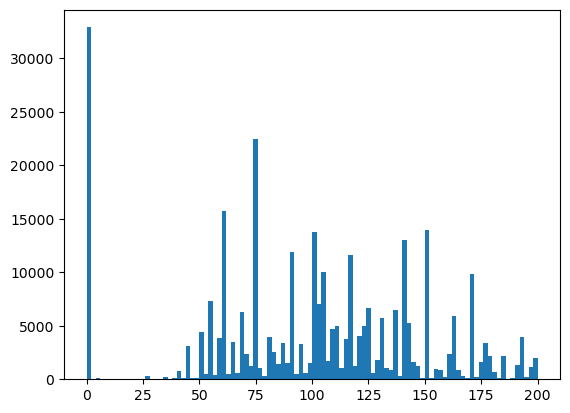

In [77]:
plt.hist(df['Power'], bins=100, range=(0, 200))
plt.show()

In [78]:
df['Power'].describe()

count    329765.000000
mean        111.902179
std         184.849228
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [79]:
len(df[df['Power'] > right_whisker(df, 'Power')]) / len(df) * 100

2.1357633466256276

In [80]:
df[df['Power'] > 1500]['Power'].count()

173

In [81]:
df = df[df['Power'] <= 1500]

In [82]:
df[df['Power'] == 0]['Power'].count()

32866

**Conclusion:** We removed the anomalous values from above, there were not many of them (185), we also changed the data type to int32. However, a lot of data with a value of 0 was found, which indicates the presence of implicit gaps. You need to fill them

Replace zero values with missing ones - NaN

In [83]:
df['Power'].replace(0, np.nan, inplace=True)

Fill in the gaps using a Linear Regression model. Add all the features to the training sample

In [84]:
features_train_p, features_test_p, target_train_p, target_test_p = prepare_data(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired'], 'Power')
print(features_train_p.shape)
print(features_test_p.shape)
print(target_train_p.shape)
print(target_test_p.shape)


(296726, 9)
(32866, 9)
(296726,)
(32866,)


In [85]:
model_regressor_p = LinearRegression()
scores_p = cross_val_score(model_regressor_p, features_train_p, target_train_p, cv=5)
final_score_p = sum(scores_p) / len(scores_p)
final_score_p

0.4211655025262992

In [86]:
model_regressor_p.fit(features_train_p, target_train_p)
target_predict_p = model_regressor_p.predict(features_test_p)
df['Power'] = join_predictions(features_train_p, target_train_p, features_test_p, target_predict_p, 'Power')
df['Power'].isna().sum()



0

In [87]:
df['Power'] = df['Power'].astype('int32')

### Kilometer

In [88]:
df['Kilometer'].describe()

count    329592.000000
mean     128207.389742
std       37520.160113
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

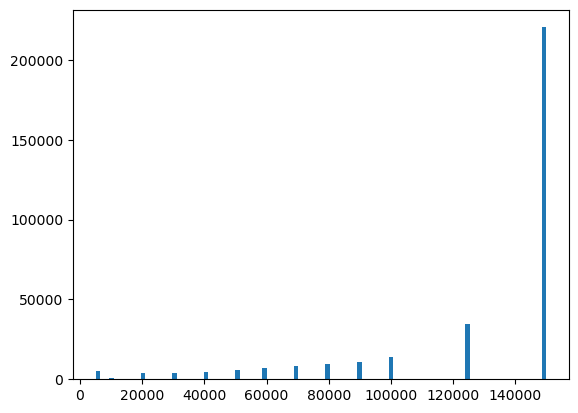

In [89]:
plt.hist(df['Kilometer'], bins=100)
plt.show()

In [90]:
df['Kilometer'].unique()

array([150000, 125000,  90000,  30000,  70000,   5000, 100000,  60000,
        20000,  80000,  50000,  40000,  10000])

In [91]:
df['Kilometer'] = df['Kilometer'].astype('int32')

**Conclusion:** No anomalous values were found in the feature, the data mimics numerical values. Also changed the data type to int32

### VehicleType

In [92]:
df['VehicleType'].unique()

array(['small', 'coupe', 'suv', 'sedan', 'convertible', 'bus', 'wagon',
       'other'], dtype=object)

### Gearbox

In [93]:
df['Gearbox'].unique()

array(['manual', 'auto'], dtype=object)

### FuelType

In [94]:
df['FuelType'].unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

### Repaired

In [95]:
df['Repaired'].unique()

array(['no', 'yes'], dtype=object)

In [96]:
df.loc[df['Repaired'] == 'no', 'Repaired'] = 0
df.loc[df['Repaired'] == 'yes', 'Repaired'] = 1
df['Repaired'].unique()

array([0, 1], dtype=object)

In [97]:
df['Repaired'] = df['Repaired'].astype('bool')

### Brand

In [98]:
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'sonstige_autos',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'citroen', 'toyota', 'chevrolet', 'dacia', 'daihatsu',
       'trabant', 'chrysler', 'jaguar', 'daewoo', 'porsche', 'rover',
       'saab', 'land_rover', 'lada'], dtype=object)

### Model

In [99]:
df['Model'].unique()

array(['golf', 'tt', 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'impreza', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'corsa', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sorento', '850', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'caddy', 'mondeo', 'cordoba', 'colt', 'vectra', 'berlingo',
       'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe',
       'ceed', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe',
       '1_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio

### Датасет после предобрабоки

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329592 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             329592 non-null  int32 
 1   VehicleType       329592 non-null  object
 2   RegistrationYear  329592 non-null  int32 
 3   Gearbox           329592 non-null  object
 4   Power             329592 non-null  int32 
 5   Model             329592 non-null  object
 6   Kilometer         329592 non-null  int32 
 7   FuelType          329592 non-null  object
 8   Brand             329592 non-null  object
 9   Repaired          329592 non-null  bool  
dtypes: bool(1), int32(4), object(5)
memory usage: 20.4+ MB


In [101]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,small,1993,manual,76,golf,150000,petrol,volkswagen,False
1,18300,coupe,2011,manual,190,tt,125000,gasoline,audi,True
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,False
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,False
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,False


**Conclusion:** The dataset size in terms of memory size has been halved from +40 MB to 20.4 MB. The number of features was reduced to 10, and all missing values were also removed. Implicit duplicates were found in the Power attribute, which could be related to the fact that an interface error was made in the frontend development - you can specify a zero value in the Power field. No significant outliers were found in the data: the amount of data in the right whisker of all features does not exceed 5 percent.

## Model trainning

### Preparing Samples for Model Training

In [102]:
features = df.drop('Price', axis=1)
target = df['Price']

In [103]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(247194, 9)
(82398, 9)
(247194,)
(82398,)


In [104]:
str_columns = []
for col in features_train.columns:
    if df[col].dtype != 'int32':
        str_columns.append(col)
        
str_columns

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

**Encoding categorical meanings**

In [105]:
encoder = TargetEncoder(cols=str_columns)
encoder.fit(features_train, target_train)
train_encoder = encoder.transform(features_train, target_train)
test_encoder = encoder.transform(features_test, target_test)

### Using models from sklearn

**Useful Functions**

In [106]:
def get_best_score(model, features, targer):
    scores = cross_val_score(model, features, targer, cv=7, scoring='neg_mean_squared_error')
    best_score = sum(list((-1 * np.array(scores)) ** 0.5)) / len(list((-1 * np.array(scores)) ** 0.5)) 
    return round(best_score, 2)

**LinearRegression**

Since TargetEncoder is not suitable for linear regression, we use OneHotEncoder

In [107]:
features_ohe = pd.get_dummies(features, columns=str_columns, drop_first=True)
train_ohe, test_ohe = train_test_split(features_ohe, test_size=0.25, random_state=12345)
print(train_ohe.shape)
print(test_ohe.shape)

(247194, 306)
(82398, 306)


Scale numeric features

In [108]:
numeric = ['Kilometer', 'RegistrationYear', 'Power']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

train_ohe[numeric] = scaler.transform(features_train[numeric])
test_ohe[numeric] = scaler.transform(features_test[numeric])

print(train_ohe.shape)
print(test_ohe.shape)

(247194, 306)
(82398, 306)


In [109]:
model_regression = LinearRegression()

start_time_fit = timeit.default_timer()
model_regression.fit(train_ohe, target_train)
elapsed_fit = timeit.default_timer() - start_time_fit

start_time_predict = timeit.default_timer()
predictions = model_regression.predict(train_ohe)
elapsed_predict = timeit.default_timer() - start_time_predict

print(f'Time of train model {round(elapsed_fit, 2)} sec')
print(f'Time of proccessing {round(elapsed_predict, 2)} sec')

Time of train model 3.82 sec
Time of proccessing 0.15 sec


Evaluate the quality of the model by RMSE

In [110]:
get_best_score(model_regression, train_ohe, target_train)

2760.21

**DecisionTreeRegressor**

In [111]:
PARAMS_TREE = {
    'max_depth': range(1, 80, 5)
}

In [112]:
model_tree = DecisionTreeRegressor(random_state=12345)
grid = GridSearchCV(model_tree, PARAMS_TREE, cv=5, scoring='neg_mean_squared_error')
grid.fit(train_encoder, target_train)

rmse = (-1 * grid.best_score_) ** 0.5

print(grid.best_params_)

{'max_depth': 16}


In [113]:
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=16)

start_time_fit = timeit.default_timer()
model_tree.fit(train_encoder, target_train)
elapsed_fit = timeit.default_timer() - start_time_fit

start_time_predict = timeit.default_timer()
predictions = model_tree.predict(train_encoder)
elapsed_predict = timeit.default_timer() - start_time_predict

print(f'Time of train model {round(elapsed_fit, 2)} sec')
print(f'Time of proccessing {round(elapsed_predict, 2)} sec')

Time of train model 0.43 sec
Time of proccessing 0.03 sec


Evaluate the quality of the model by RMSE

In [114]:
get_best_score(model_tree, train_encoder, target_train)

1855.49

**Conclusion:** DecisionTreeRegressor - A model that could potentially be the best model for a given task. However, it is necessary to experiment with other models

### Using models from LightGBM without boosting

In [115]:
model_reg = lgb.LGBMRegressor(boosting_type=None, max_depth=40, n_estimators=100, random_state=627361)

start_time_fit = timeit.default_timer()
model_reg.fit(train_encoder, target_train)
elapsed_fit = timeit.default_timer() - start_time_fit

start_time_predict = timeit.default_timer()
predictions = model_reg.predict(train_encoder)
elapsed_predict = timeit.default_timer() - start_time_predict

print(f'Time of train model {round(elapsed_fit, 2)} sec')
print(f'Time of proccessing {round(elapsed_predict, 2)} sec')

Time of train model 0.37 sec
Time of proccessing 0.21 sec


Evaluate the quality of the model by RMSE

In [116]:
get_best_score(model_reg, train_encoder, target_train)

1705.76

**Conclusion:** We trained a model from the LightGBM library. The advantages over sklearn are as follows: RMSE is in the range (1700, 2000), which is approximately equal to the **Random Tree model**, but the learning rate was ~0.5

### Building a Boosted Model

**dart**

In [117]:
model_lgb_dart = lgb.LGBMRegressor(boosting_type='dart', max_depth=60, n_estimators=200, random_state=627361)

start_time_fit = timeit.default_timer()
model_lgb_dart.fit(train_encoder, target_train)
elapsed_fit = timeit.default_timer() - start_time_fit

start_time_predict = timeit.default_timer()
predictions = model_lgb_dart.predict(train_encoder)
elapsed_predict = timeit.default_timer() - start_time_predict

print(f'Time of train model {round(elapsed_fit, 2)} sec')
print(f'Time of proccessing {round(elapsed_predict, 2)} sec')

Time of train model 6.0 sec
Time of proccessing 0.4 sec


Evaluate the quality of the model by RMSE

In [118]:
get_best_score(model_lgb_dart, train_encoder, target_train)

1805.81

**gbdt**

In [119]:
model_lgb_gbdt = lgb.LGBMRegressor(boosting_type='gbdt',max_depth=60, random_state=627361)

start_time_fit = timeit.default_timer()
model_lgb_gbdt.fit(train_encoder, target_train)
elapsed_fit = timeit.default_timer() - start_time_fit

start_time_predict = timeit.default_timer()
predictions = model_lgb_gbdt.predict(train_encoder)
elapsed_predict = timeit.default_timer() - start_time_predict

print(f'Time of train model {round(elapsed_fit, 2)} sec')
print(f'Time of proccessing {round(elapsed_predict, 2)} sec')

Time of train model 0.43 sec
Time of proccessing 0.21 sec


Evaluate the quality of the model by RMSE

In [120]:
get_best_score(model_lgb_gbdt, train_encoder, target_train)

1705.76

## Model Analysis

Training models of all possible models showed the following results:
### sklearn library
**LinearRegression** \
Training time: 3.73sec\
Prediction time: 0.18sec\
RMSE = 2760.21
\
**DecisionTreeRegressor** \
Training time: 0.42sec\
Prediction Time: 0.03sec\
RMSE = 1855.49
### LightGBM Library
**No boosting** \
Training time: 0.38 s \
Prediction time = 0.22 s \
RMSE = 1705.76 \\
\
**Boosting: dart** \
Training time: 5.77 s \
Prediction time = 0.39 s \
RMSE = 1805.81 \\
\
**Boosting: gbdt** \
Training time: 0.36 s \
Prediction time = 0.21 s \
RMSE = 1705.76

**Conclusion:** The best model regarding learning rate and metric is LGBMRegressor where max_depth = 60, boosting_type='gbdt'

**Let's check the quality of the model on the test sample**

In [121]:
model_lgb_gbdt = lgb.LGBMRegressor(boosting_type='gbdt',max_depth=60, random_state=627361)

start_time_fit = timeit.default_timer()
model_lgb_gbdt.fit(train_encoder, target_train)
elapsed_fit = timeit.default_timer() - start_time_fit

start_time_predict = timeit.default_timer()
predictions = model_lgb_gbdt.predict(test_encoder)
elapsed_predict = timeit.default_timer() - start_time_predict

rmse = mean_squared_error(target_test, predictions) ** 0.5

print(f'RMSE = {rmse}')
print(f'Time of train model {round(elapsed_fit, 2)} sec')
print(f'Time of proccessing {round(elapsed_predict, 2)} sec')

RMSE = 1713.0566794522065
Time of train model 0.35 sec
Time of proccessing 0.07 sec


**Conclusion:** Metric, learning rate and prediction satisfies the task at hand